# Analysis of total accessible market for automated utility-scale solar PV design

In [757]:
%%capture
!{sys.executable} -m pip install pandas tabulate matplotlib openpyxl
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, HTML

%matplotlib inline


In [758]:
# Helper functions
from IPython.display import display, HTML
import uuid  # To generate unique class names

def get_styled_html_table(df, last_bold=True):
    """Returns an HTML-styled table with or without the last row in bold."""
    unique_class = f"table_{uuid.uuid4().hex[:8]}"  # Generate a unique class
    html_table = df.to_html(index=False, escape=False, classes=unique_class)  # Assign class to table

    if last_bold:
        return _last_bold(html_table, unique_class)
    return _last_normal(html_table, unique_class)


def _last_bold(html_table, unique_class):
    styled_html = f"""
    <style>
        .{unique_class} tr:last-child td {{
            font-weight: bold;
        }}
    </style>
    {html_table}
    """
    return styled_html


def _last_normal(html_table, unique_class):
    styled_html = f"""
    <style>
        .{unique_class} tr:last-child td {{
            font-weight: normal;
        }}
    </style>
    {html_table}
    """
    return styled_html


In [759]:
# Get and process new capacity data
source = r'/Users/paul/Library/CloudStorage/OneDrive-SharedLibraries-7SecondSolar/The Company - Documents/01 Admin/1.1 Business Plan/Refund/Financial Model.xlsx'

new_capacity = pd.read_excel(source, sheet_name='new_capacity')
new_capacity = new_capacity.dropna()
utility = new_capacity["utility"].values[0]
distributed = new_capacity["distributed"].values[0]

In [760]:
# Get and process capacity growth data
annual_growth = pd.read_excel(source, sheet_name='annual_growth')
annual_growth = annual_growth.dropna()

annual_growth['Capacity'] = annual_growth['share'].apply(lambda x: x * (float(utility) + float(distributed)))
annual_growth.columns = ['Year', 'Share of growth', 'Capacity [GW]']
annual_growth['Share of growth'] = annual_growth['Share of growth'].apply(lambda x: f"{100 * x:.0f}%")
annual_growth['Capacity [GW]'] = annual_growth['Capacity [GW]'].apply(lambda x: f"{x:,.0f}")
total_capacity = annual_growth['Capacity [GW]'].str.replace(',', '').astype(float).sum()
annual_growth.loc[len(annual_growth.index)] = ['Total', '', f"{total_capacity:,.0f}"]


In [761]:
# Get regional share of new_capacity
regional_capacity = pd.read_excel(source, sheet_name='world_share')
regional_capacity = regional_capacity.dropna()

regional_capacity.columns = ['Region', 'Share']
regional_capacity['Utility [GW]'] = regional_capacity['Share'].apply(
    lambda x: x * (float(utility)))
regional_capacity['Distributed [GW]'] = regional_capacity['Share'].apply(
    lambda x: x * (float(distributed)))
regional_capacity['Total Capacity [GW]'] = regional_capacity['Utility [GW]'] + regional_capacity['Distributed [GW]']

rest_of_world = regional_capacity[regional_capacity['Region'] == 'Rest of World']
regional_capacity = regional_capacity[regional_capacity['Region'] != 'Rest of World']
regional_capacity = regional_capacity.sort_values(by='Total Capacity [GW]', ascending=False)
regional_capacity = pd.concat([regional_capacity, rest_of_world])

total_capacity = regional_capacity['Total Capacity [GW]'].sum()
regional_capacity['Share'] = regional_capacity['Share'].apply(lambda x: f"{100 * x:.0f}%")

In [762]:
# Get and process regional cost of engineering data
engineering_cost = pd.read_excel(source, sheet_name='engineering_cost')
engineering_cost = engineering_cost[['Region', 'Country', 'System design']]
engineering_cost.rename(columns={'System design': 'System design cost [US$/kW]'}, inplace=True)
region_avg = engineering_cost.groupby("Region", as_index=False)['System design cost [US$/kW]'].mean()
region_avg = region_avg.sort_values(by='System design cost [US$/kW]', ascending=False)

In [763]:
# Combining engineering cost and market size per region
regional_capacity = regional_capacity.merge(region_avg, on='Region', how='left')
weighted_average_cost_utility_cost = (
        regional_capacity['Utility [GW]'] * 1000_000 * regional_capacity['System design cost [US$/kW]']
).sum()


In [764]:
# Introduction
display(Markdown("""
## Introduction

The IEA estimates [[1](#ref1)] an additional {} GW of utility-scale and a further {} GW of distributed solar PV will be installed globally between 2024 and 2030. This paper discusses value of system design that can reasonably displaced by accurately automating the detail design of utility-scale solar PV.

""".format(f":{utility: ,.0f}", f"{distributed: ,.0f}")))


## Introduction

The IEA estimates [[1](#ref1)] an additional : 2,550 GW of utility-scale and a further  1,659 GW of distributed solar PV will be installed globally between 2024 and 2030. This paper discusses value of system design that can reasonably displaced by accurately automating the detail design of utility-scale solar PV.



In [765]:
assumptions = pd.read_excel(source, sheet_name='assumptions')

assumption_ratio=assumptions.loc[assumptions['assumption']=='concept_ratio']
concept_to_design_ratio = assumption_ratio.loc[assumption_ratio['assumption']=='concept_ratio', 'concept'].values[0]

assumptions.drop(assumption_ratio.index, inplace=True)
assumptions['assumption'] = assumptions['assumption'].replace({
    'projects': 'Share of projects that could benefit from automated design',
    'design': 'Portion of utility design process that could be automated',
    'distributed': 'Share of distributed projects that could be automated using AUTOPV',
})

assumptions_display = assumptions.copy()
assumptions_display['detail'] = assumptions_display['detail'].apply(lambda x: f"{100 * x:.0f}%")
assumptions_display['concept'] = assumptions_display['concept'].apply(lambda x: f"{100 * x:.0f}%")
assumptions_display.columns = ['Assumptions', 'Detail design projects', 'Concept design projects']




In [766]:
display(Markdown("""
## Approach and assumptions

AUTOPV automates the detailed engineering of utility-scale solar. Quantifying the total market of engineering value that could be displaced by automated design, we look at the International Energy Agency's (IEA) capacity increase forecasts for the next five years [[1](#ref1)] and the Internation Renewable Energy Agency's (IRENA) report [[2](#ref2)] on the regional solar PV installation and development costs.

The IEA report looks only at projects that will go to construction. In our experience, for every project that makes its way to construction, at least {} more projects do not progress beyond the Concept design phase. We consider the impact of AUTOPV on both projects that move to construction and those that do not. We refer to these as Detail Design and Concept Design projects.

To find a reasonable answer, we make several assumptions. Firstly, we acknowledge that some projects will be too complex for automation and will always require bespoke or traditional approaches. We are also aware that the human engineer will likely never be entirely removed from the design process. Areas such as geotechnical investigations, earthing and lightning studies, among others, are more complicated to automate reliably. Lastly, we believe that a portion of the distributed or embedded solar PV will also be suitable for a product like AUTOPV.

Our assumptions about the amount of traditional design effort that AUTOPV can displace are listed below and shown as a percentage of the total effort for Detail design and Concept design projects, respectively:


""".format(f'{concept_to_design_ratio-1:.0f}')))
display(HTML(get_styled_html_table(assumptions_display, last_bold=False)))


## Approach and assumptions

AUTOPV automates the detailed engineering of utility-scale solar. Quantifying the total market of engineering value that could be displaced by automated design, we look at the International Energy Agency's (IEA) capacity increase forecasts for the next five years [[1](#ref1)] and the Internation Renewable Energy Agency's (IRENA) report [[2](#ref2)] on the regional solar PV installation and development costs.

The IEA report looks only at projects that will go to construction. In our experience, for every project that makes its way to construction, at least 2 more projects do not progress beyond the Concept design phase. We consider the impact of AUTOPV on both projects that move to construction and those that do not. We refer to these as Detail Design and Concept Design projects.

To find a reasonable answer, we make several assumptions. Firstly, we acknowledge that some projects will be too complex for automation and will always require bespoke or traditional approaches. We are also aware that the human engineer will likely never be entirely removed from the design process. Areas such as geotechnical investigations, earthing and lightning studies, among others, are more complicated to automate reliably. Lastly, we believe that a portion of the distributed or embedded solar PV will also be suitable for a product like AUTOPV.

Our assumptions about the amount of traditional design effort that AUTOPV can displace are listed below and shown as a percentage of the total effort for Detail design and Concept design projects, respectively:




Assumptions,Detail design projects,Concept design projects
Share of projects that could benefit from automated design,90%,100%
Portion of utility design process that could be automated,75%,100%
Share of distributed projects that could be automated using AUTOPV,10%,10%


In [767]:
# Breaking Down Solar PV Growth
display(Markdown("""
## Breaking down the solar PV growth
We use the _Cumulative renewable capacity in the accelerated case by country or region, 2030_, graph presented in the IEA report [[1](#ref1)] to apportion the capacity additions to the various regions.
"""))
display(HTML(get_styled_html_table(regional_capacity, last_bold=False)))


## Breaking down the solar PV growth
We use the _Cumulative renewable capacity in the accelerated case by country or region, 2030_, graph presented in the IEA report [[1](#ref1)] to apportion the capacity additions to the various regions.


Region,Share,Utility [GW],Distributed [GW],Total Capacity [GW],System design cost [US$/kW]
China,48%,1224.0,796.32,2020.32,7.000000
EU,13%,331.5,215.67,547.17,8.142105
US,9%,229.5,149.31,378.81,25.800000
India,6%,153.0,99.54,252.54,12.800000
MEA,4%,102.0,66.36,168.36,12.133333
Rest of World,20%,510.0,331.80,841.80,15.012500


In [768]:
display(Markdown("""
It is clear that China is by far the most promising growth market for utility-scale solar PV, with the EU and US making up a combined 22% of the capacity growth in the next five years.
"""))


It is clear that China is by far the most promising growth market for utility-scale solar PV, with the EU and US making up a combined 22% of the capacity growth in the next five years.


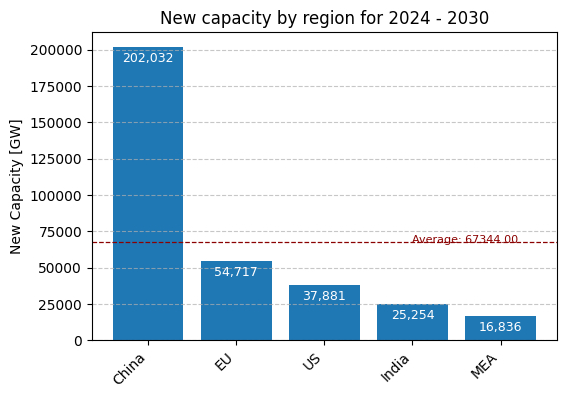

In [769]:
regional_plot = regional_capacity.copy()[:-1]
regional_plot['Total Capacity [GW]'] = regional_plot['Total Capacity [GW]'].apply(lambda x: f"{100 * x:.0f}")
regional_plot.loc[:, 'Total Capacity [GW]'] = pd.to_numeric(regional_plot['Total Capacity [GW]'].str.replace(",", ""))

plt.figure(figsize=(6, 4))
bars = plt.bar(regional_plot['Region'], regional_plot["Total Capacity [GW]"])
plt.ylabel("New Capacity [GW]")
plt.title("New capacity by region for 2024 - 2030")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

average_cost = regional_plot['Total Capacity [GW]'].mean()
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(regional_plot["Region"]) - 0.8, y=average_cost - 100, s=f"Average: {average_cost:.2f}", color='darkred',
         fontsize=8, ha='right')

# Add data labels
min_height = 1000_000_000
for bar in bars:
    if (height := bar.get_height()) < min_height:
        min_height = height

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (centered on bar)
        height - min_height * 0.2,  # Y position (slightly below the top)
        f"{height:,.0f}",  # Format number with commas
        ha='center', va='top', fontsize=9, color="white"
    )

plt.show()

In [770]:
display(Markdown("""
In our analysis, we wish to gain an annual view of the growth between 2024 and 2030. This is not explicitly available from the IEA data, so we will assume an annual proportional growth as follows:
"""))

# Display the centered table
display(HTML(get_styled_html_table(annual_growth, last_bold=True)))



In our analysis, we wish to gain an annual view of the growth between 2024 and 2030. This is not explicitly available from the IEA data, so we will assume an annual proportional growth as follows:


Year,Share of growth,Capacity [GW]
2025,10%,421
2026,15%,631
2027,20%,842
2028,25%,"1,052"
2029,30%,"1,263"
Total,,"4,209"


In [771]:
# The Cost of Engineering Design
display(Markdown("""
## The Cost of Engineering Design

The cost to design utility-scale solar PV varies significantly across regions. The following breakdown is from IRENA _Renewable power generation costs in 2023_ report [[2](#ref2)]. 
"""))


## The Cost of Engineering Design

The cost to design utility-scale solar PV varies significantly across regions. The following breakdown is from IRENA _Renewable power generation costs in 2023_ report [[2](#ref2)]. 


In [772]:
display(Markdown("""
The following figure shows these costs aggregated by region. 
"""))


The following figure shows these costs aggregated by region. 


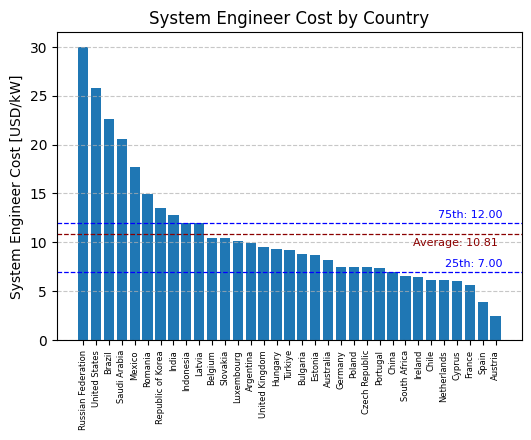

In [773]:
# Regional cost of engineering plot
plt.figure(figsize=(6, 4))
plt.bar(engineering_cost["Country"], engineering_cost["System design cost [US$/kW]"])
plt.ylabel("System Engineer Cost [USD/kW]", fontsize=10)
plt.title("System Engineer Cost by Country")
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Average
average_cost = engineering_cost["System design cost [US$/kW]"].mean()
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.8, y=average_cost - 1.2, s=f"Average: {average_cost:.2f}",
         color='darkred', fontsize=8, ha='right')

# Quantiles
percentile_25 = engineering_cost["System design cost [US$/kW]"].quantile(0.25)
percentile_75 = engineering_cost["System design cost [US$/kW]"].quantile(0.75)

# Plot 25th percentile line
plt.axhline(y=percentile_25, color='blue', linestyle='--', linewidth=0.9, label=f"25th: {percentile_25:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.5, y=percentile_25 + 0.5,
         s=f"25th: {percentile_25:.2f}", color='blue', fontsize=8, ha='right')

# Plot 75th percentile line
plt.axhline(y=percentile_75, color='blue', linestyle='--', linewidth=0.9, label=f"75th: {percentile_75:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.5, y=percentile_75 + 0.5,
         s=f"75th: {percentile_75:.2f}", color='blue', fontsize=8, ha='right')

# Show the plot
plt.show()

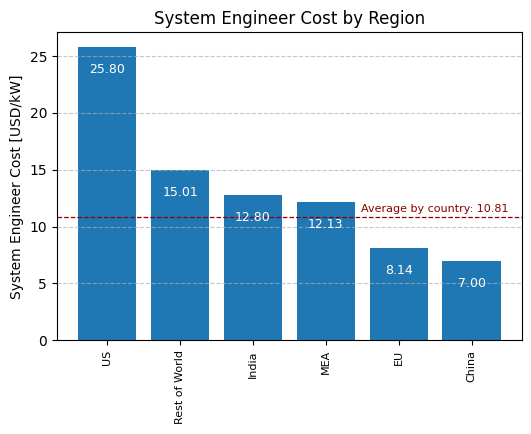

In [774]:
# Regional cost of engineering plot
plt.figure(figsize=(6, 4))
bars = plt.bar(region_avg["Region"], region_avg["System design cost [US$/kW]"])
plt.ylabel("System Engineer Cost [USD/kW]")
plt.title("System Engineer Cost by Region")
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Average
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(region_avg["Region"]) - 0.5, y=average_cost + 0.5, s=f"Average by country: {average_cost:.2f}",
         color='darkred', fontsize=8, ha='right')

# Add data labels
min_height = 1000_000_000
for bar in bars:
    if (height := bar.get_height()) < min_height:
        min_height = height

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (centered on bar)
        height - min_height * 0.2,  # Y position (slightly below the top)
        f"{height:,.2f}",  # Format number with commas
        ha='center', va='top', fontsize=9, color="white"
    )

# Show the plot
plt.show()

In [775]:
display(Markdown("""
Considering the weighted cost per region to design solar PV, completing the design of {} GW of utility scale solar will cost approximately US${}B.
""".format(f"{regional_capacity['Utility [GW]'].sum()}", f"{weighted_average_cost_utility_cost / 1000_000_000:,.1f}")))


Considering the weighted cost per region to design solar PV, completing the design of 2550.0 GW of utility scale solar will cost approximately US$28.0B.


## References

\[<a id="ref1">1</a>\] IEA (2024), Renewables 2024, IEA, Paris https://www.iea.org/reports/renewables-2024, Licence: CC BY 4.0

\[<a id="ref2">2</a>\] IRENA (2024), Renewable power generation costs in 2023, International Renewable Energy Agency, Abu Dhabi. https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2024/Sep/IRENA_Renewable_power_generation_costs_in_2023.pdf